In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
stocks = pd.read_csv("~/Stock_Prediction_ML/StockPredictions/Stock_Predictions/data/S&P_500_GOOGFIN_3MO.csv")

In [4]:
def get_stock_data(name):
    return stocks.loc[stocks['Stock'] == name]

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
u_stocks = np.unique(stocks['Stock'])
labels, uniques = pd.factorize(stocks['Stock'])
labels.transpose
stocks['ID'] = labels
stocks_id = stocks.drop(['Stock'], axis = 1)
stocks_id = stocks_id.set_index('Date')
print(stocks_id)

         Open    High     Low   Close   Volume   ID
Date                                               
43756   74.00   74.82   73.77   74.57  2121895    0
43759   74.88   75.51   74.69   75.48  1739523    0
43760   75.68   76.33   74.64   74.69  1327981    0
43761   75.02   75.89   74.68   74.98  1828337    0
43762   75.03   75.11   74.46   75.00  1582478    0
...       ...     ...     ...     ...      ...  ...
43843  136.07  136.75  135.46  136.51  1801255  514
43844  136.42  137.28  135.52  137.27  1848833  514
43845  137.41  139.00  137.34  138.54  1859576  514
43846  138.78  139.40  138.02  139.24  1822882  514
43847  139.62  140.40  138.86  140.16  1993175  514

[31815 rows x 6 columns]


In [18]:
stocks_val = stocks_id.values
stocks_val = stocks_val.astype('float64')

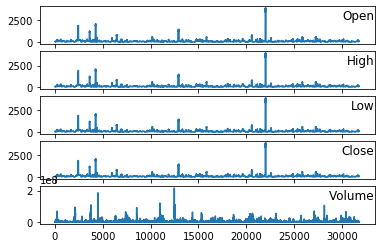

In [20]:
groups = [0, 1, 2, 3, 4]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(stocks_val[:, group])
    plt.title(stocks_id.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(stocks_val)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[7, 8, 9, 10, 11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.016811   0.016816   0.016925   0.016951   0.009826        0.0  0.017037
2   0.017037   0.016991   0.017163   0.017184   0.008055        0.0  0.017243
3   0.017243   0.017200   0.017150   0.016981   0.006150        0.0  0.017073
4   0.017073   0.017088   0.017161   0.017056   0.008467        0.0  0.017076
5   0.017076   0.016890   0.017104   0.017061   0.007328        0.0  0.016991


In [25]:
values = reframed.values

In [26]:
n_train = int(values.shape[0] * 0.67)
train = values[:n_train,:]
test = values[n_train:,:]

In [27]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [28]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21315, 1, 6) (21315,) (10499, 1, 6) (10499,)


Train on 21315 samples, validate on 10499 samples
Epoch 1/50
 - 6s - loss: 0.0045 - val_loss: 0.0073
Epoch 2/50
 - 5s - loss: 0.0028 - val_loss: 0.0025
Epoch 3/50
 - 5s - loss: 0.0020 - val_loss: 0.0061
Epoch 4/50
 - 5s - loss: 0.0023 - val_loss: 0.0033
Epoch 5/50
 - 5s - loss: 0.0015 - val_loss: 0.0017
Epoch 6/50
 - 5s - loss: 0.0015 - val_loss: 0.0018
Epoch 7/50
 - 5s - loss: 0.0015 - val_loss: 0.0016
Epoch 8/50
 - 5s - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
 - 6s - loss: 0.0020 - val_loss: 0.0022
Epoch 10/50
 - 6s - loss: 0.0018 - val_loss: 0.0048
Epoch 11/50
 - 6s - loss: 0.0019 - val_loss: 0.0040
Epoch 12/50
 - 6s - loss: 0.0019 - val_loss: 0.0030
Epoch 13/50
 - 6s - loss: 0.0019 - val_loss: 0.0038
Epoch 14/50
 - 6s - loss: 0.0015 - val_loss: 0.0071
Epoch 15/50
 - 6s - loss: 0.0014 - val_loss: 0.0026
Epoch 16/50
 - 5s - loss: 0.0013 - val_loss: 0.0016
Epoch 17/50
 - 5s - loss: 0.0017 - val_loss: 0.0057
Epoch 18/50
 - 5s - loss: 0.0020 - val_loss: 0.0032
Epoch 19/50
 - 5s - los

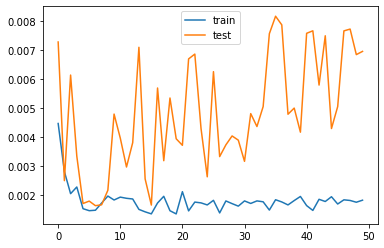

In [29]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test), verbose=2,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()